# Going Deeper - The mechanism of pytorch
- Working with pytorch computation graphs
- Working with pytorch tensor objects
- Solving the classic XOR problem and understanding model capacity
- Building compolex nn models using Sequential class and the nn.Module class
- Comupting gradients using automatic differentiation and torch.autograd

## PyTorch's computation graphs

In [1]:
# Creating a graph in pytorch
import torch
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [2]:
print('Scalar inputs: ', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 inputs: ', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 inputs: ', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar inputs:  tensor(1)
Rank 1 inputs:  tensor([1])
Rank 2 inputs:  tensor([[1]])


## Pytorch tensor objects for string and updating model parameters
- Initialize with requires_grad=True
- Only tensors of floating point and complex dtype can require gradients
- requires_grad=False by default, but can be set by requires_grad_()

In [3]:
# Generate tensor objects of type float32
a = torch.tensor(3.14, requires_grad=True)
print(a)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [4]:
# Set requires_grad
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)
w.requires_grad_()
print(w.requires_grad)

False
True


In [5]:
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty((2, 3))
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [6]:
# Define two Tensor objects inside the base nn.Module class
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty((2, 3), requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w1 = torch.empty((1, 2), requires_grad=True)
        nn.init.xavier_normal_(self.w2)

### Computing gradients via automatic differentiation

In [7]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
# loss = (y - z).pow(2).sum()
loss = torch.sum(torch.pow((y-z), 2))
loss.backward()
print('dL/dw: ', w.grad)
print('dL/db: ', b.grad)

dL/dw:  tensor(-0.5600)
dL/db:  tensor(-0.4000)


### Implementing models based on nn.Sequential

In [8]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [9]:
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

### Build an NN for XOR classification task

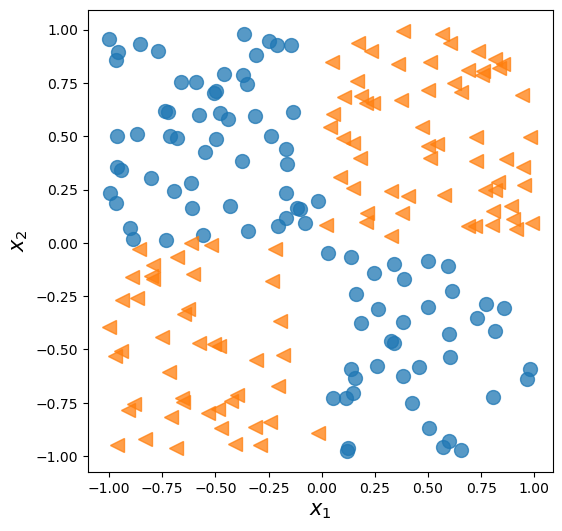

In [10]:
# Generate 200 samples from uniform dist. x_i = U([-1.0, 1.0]), y = 1 iff x_1 * x_2 < 0.
# 100 training + 100 testing
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [11]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
# Model, loss function, optimizer, dataset and dataloader
batch_size = 2
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
torch.manual_seed(1)
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [12]:
torch.manual_seed(1)
num_epochs = 200

def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred >= 0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
            

# Train for 200 epochs\
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

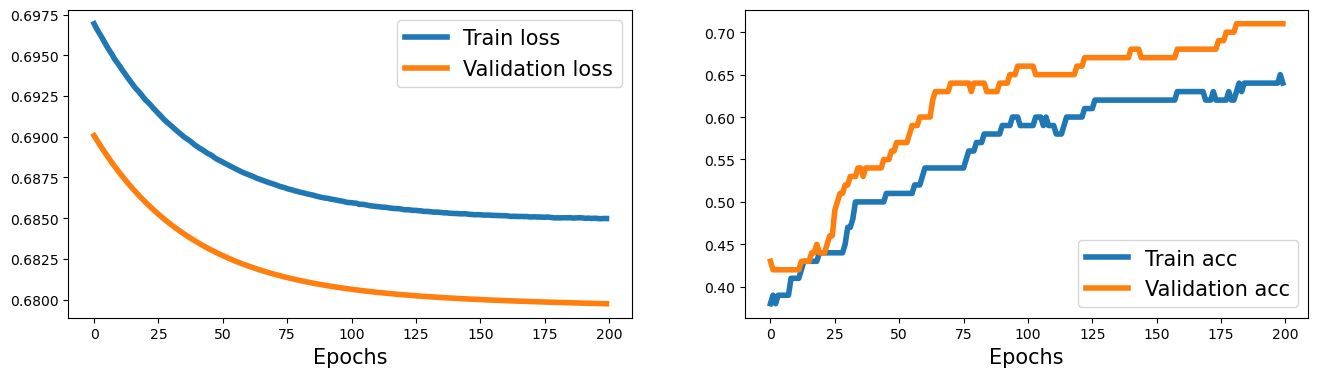

In [13]:
# Plotting
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc', 'Validation acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [18]:
# A custom module
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [19]:
model = MyModule()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

/var/folders/pg/qydlmtzs3bx2sy9z5fgl3s1r0000gn/T/ipykernel_3163/2522836890.py:14: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.integer), clf=model)


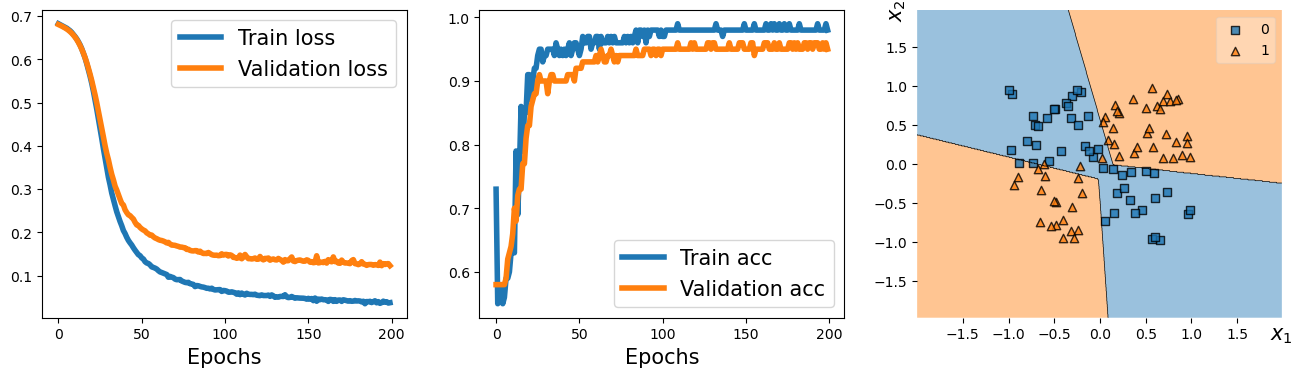

In [20]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc', 'Validation acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.integer), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### Defining a customized layer
- Define a subclass of nn.Module
- Define \_\_init\_\_() and forward() methods

e.g. Defining a noisy linear layer that computes w(x+$\epsilon$) + b

In [ ]:
class NoisyLiear(nn.Module):
    def __init__(self, input_size, output_size, noise_std=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w) # nn.Parameter is a tensor that's a module parameter
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(input_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_std = noise_std
    
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_std, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)